In [2]:
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cartopy.crs as ccrs

DATADIR = './data/cmip6_agg/'

In [20]:


def geog_agg(fn):
    ds = xr.open_dataset(f'{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    try:
        da = da.reset_coords(names='height', drop=True)
    except Exeption as e:
        pass
    # weights = np.cos(np.deg2rad(da.lat))
    # weights.name = "weights"
    # da_weighted = da.weighted(weights)
    # da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

# for filename, model_name in zip(glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'), data_into_list):
#     # print(filename)
#     data = xr.open_dataset(filename)
#     data = data.rename({'tas': model_name})
#     data = data.convert_calendar("noleap", align_on='date')
#     data = data.resample(time='1M').first()
#     try:
#         data = data.drop_vars('height')
#     except ValueError:
#         print('column has no height var')
#     # try:
#     #     data.indexes['time'].to_datetimeindex()
#     # except AttributeError:
#     #     pass
#     data_l.append(data)

# big_df = xr.merge(data_l)

In [21]:
for filename in glob.glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc'):
    try:
        geog_agg(filename)
    except Exception as e: 
        print(f'{filename} failed {e}')

data\tas_scenario_245\tas_mon_mod_ssp245_192_000.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_ACCESS-CM2_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_001.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_ACCESS-ESM1-5_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_002.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_AWI-CM-1-1-MR_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_003.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6_agg\\cmip6_agg_historical_BCC-CSM2-MR_1850.nc'
data\tas_scenario_245\tas_mon_mod_ssp245_192_004.nc failed [Errno 13] Permission denied: b'c:\\Users\\jqcla\\Documents\\GitHub\\Honours-Thesis\\code\\data\\cmip6

In [3]:
data_ds = xr.open_mfdataset(f'cmip6_agg*.nc', coords='minimal', compat='override')
data_ds.load()

<xarray.Dataset>
Dimensions:     (year: 251, model: 36, experiment: 1)
Coordinates:
    height      float64 2.0
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical'
Data variables:
    tas         (experiment, model, year) float32 13.7 13.71 ... 17.6 17.62

C:\Users\jqcla\AppData\Local\Temp\ipykernel_10264\3480747382.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in p.axes.flat:


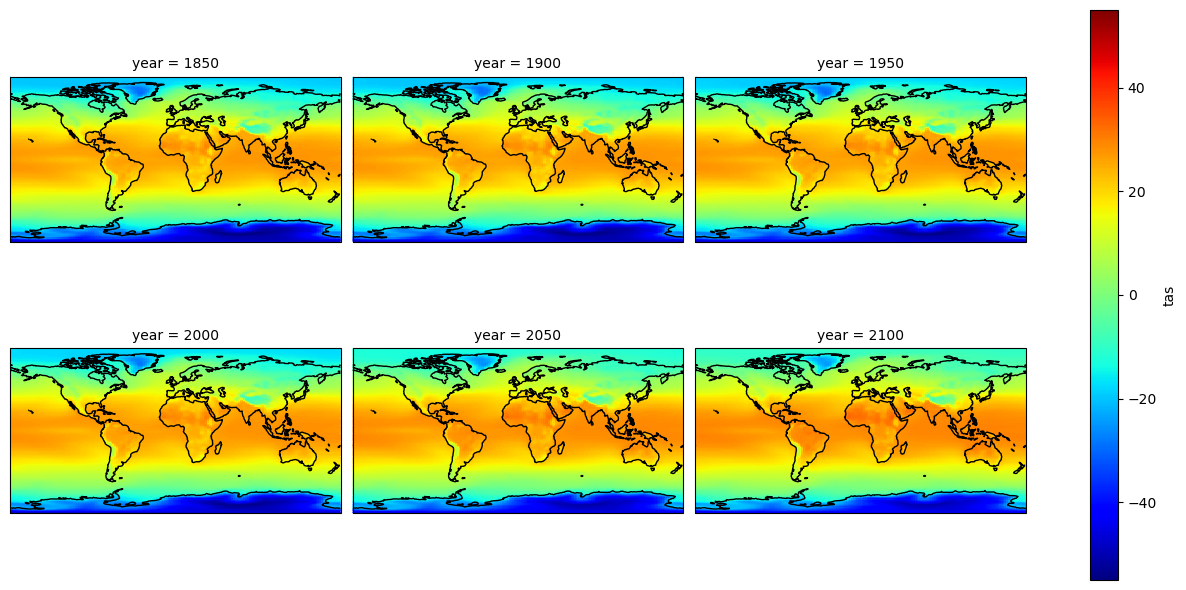

In [27]:
# many_times = np.array([
#     "1850-01-16",
#     "1900-01-16",
#     "1950-01-16",
#     "2000-01-16",
#     "2050-01-16",
#     "2100-01-16",
# ], dtype=np.datetime64)
many_times = [1850, 1900, 1950, 2000, 2050, 2100]


temp = data_ds['tas'].sel(year=many_times, method='nearest')
data_50 = temp.quantile(0.5, dim='model')
# display(data_50)
map_proj = ccrs.PlateCarree(central_longitude=0)

p = data_50.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='year', col_wrap=3,  # multiplot settings
             aspect=data_ds.dims['lon'] / data_ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': map_proj},
             cmap='jet')

for ax in p.axes.flat:
    ax.coastlines()
    ax.set_ylabel('Longtitude')
    ax.set_xlabel('Latitude')
    # ax.set_extent([288, 336, -44, -12])
    # Without this aspect attributes the maps will look chaotic and the
    # "extent" attribute above will be ignored
    # ax.set_aspect('equal', 'box-forced')

plt.show()

In [5]:
data = data_ds['tas']
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

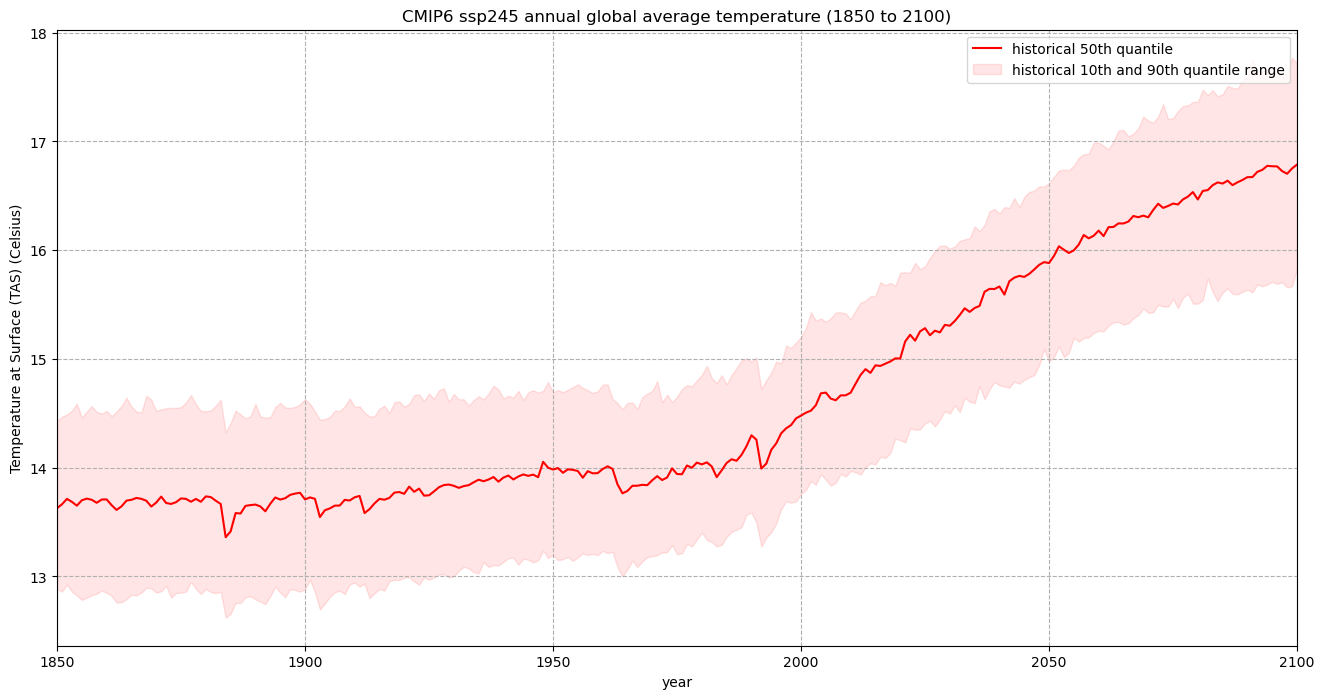

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['red']
experiments = ['ssp245']

for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

# fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

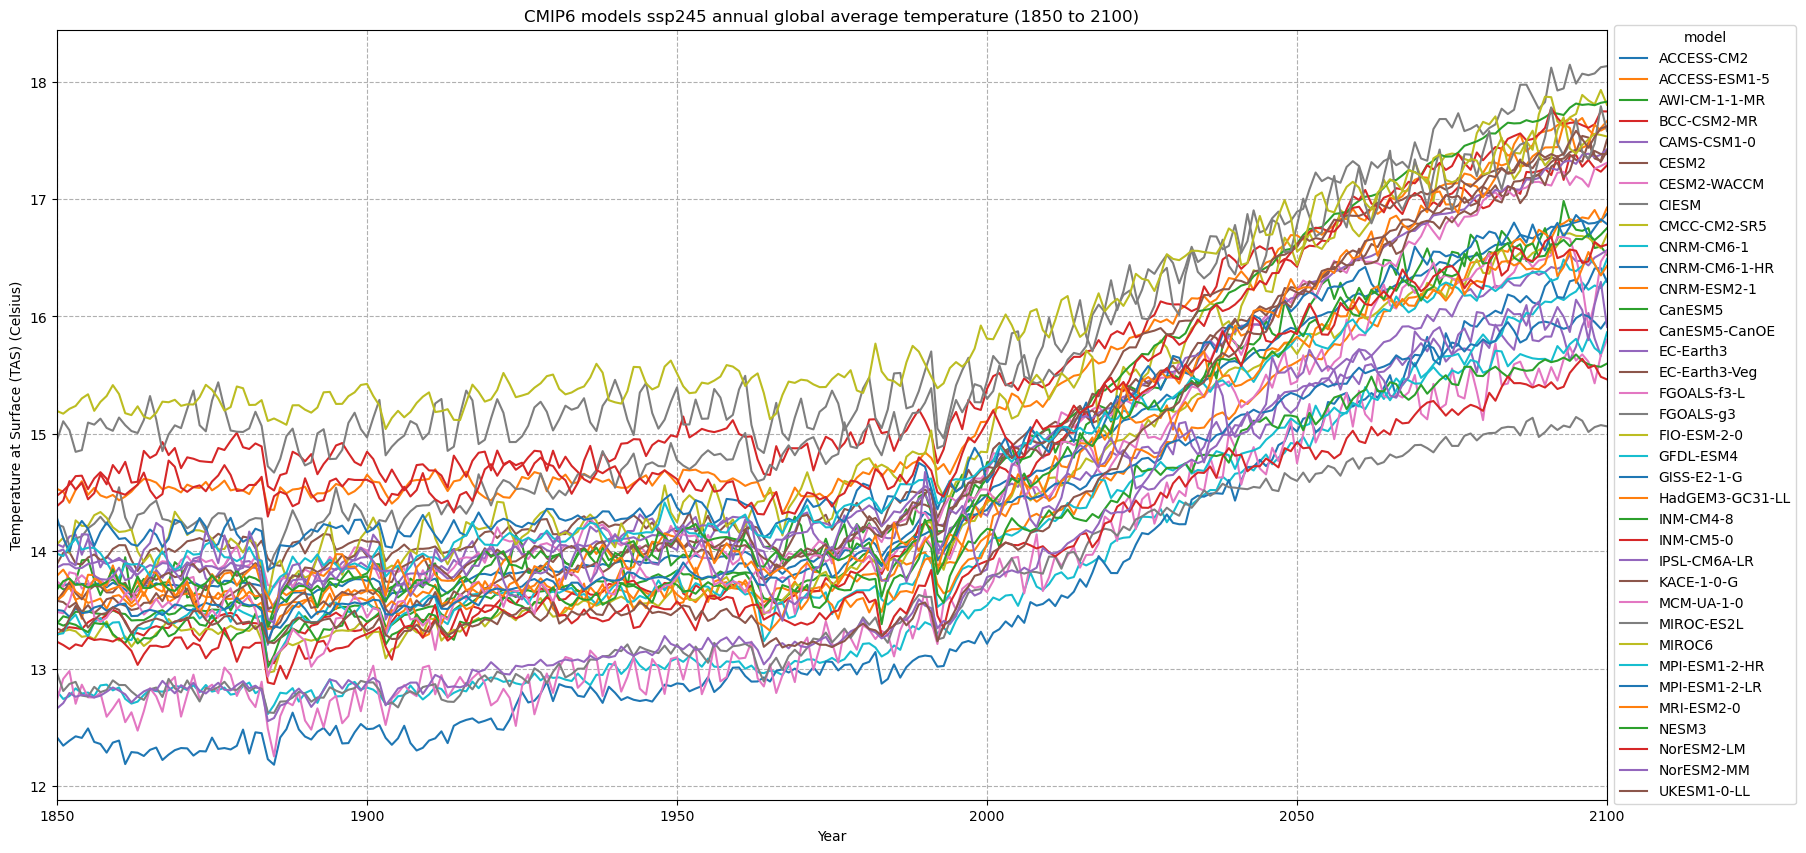

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (20, 10))
data.plot(x='year', hue='model', add_legend=True)
ax.set_xlim(1850,2100)
ax.set_title('CMIP6 models ssp245 annual global average temperature (1850 to 2100)')
ax.set_ylabel('Temperature at Surface (TAS) (Celsius)')
ax.set_xlabel('Year')
sns.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5))
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='right', bbox_to_anchor=(1, 0.5))
# ax.legend(loc='upper left')
ax.grid(linestyle='--')
plt.show()

In [14]:
tmp = data_ds.to_dataframe().reset_index()
tmp

,lon,lat,year,model,experiment,tas
0,0.000,-89.375,1850,ACCESS-CM2,historical,-46.530746
1,0.000,-89.375,1850,ACCESS-ESM1-5,historical,-46.736160
2,0.000,-89.375,1850,AWI-CM-1-1-MR,historical,-47.664902
3,0.000,-89.375,1850,BCC-CSM2-MR,historical,-45.871475
4,0.000,-89.375,1850,CAMS-CSM1-0,historical,-40.815903
...,...,...,...,...,...,...
249827323,358.125,89.375,2100,MRI-ESM2-0,historical,-10.347168
249827324,358.125,89.375,2100,NESM3,historical,-9.913055
249827325,358.125,89.375,2100,NorESM2-LM,historical,-11.597412
249827326,358.125,89.375,2100,NorESM2-MM,historical,-14.474213


In [15]:
tmp['tas'].isna().sum()

27648

In [16]:
pivot_df = tmp.pivot(index=['year', 'lat', 'lon'], columns='model', values='tas').reset_index()

In [17]:
pivot_df.isna().sum()

model
year                   0
lat                    0
lon                    0
ACCESS-CM2             0
ACCESS-ESM1-5          0
AWI-CM-1-1-MR          0
BCC-CSM2-MR            0
CAMS-CSM1-0        27648
CESM2                  0
CESM2-WACCM            0
CIESM                  0
CMCC-CM2-SR5           0
CNRM-CM6-1             0
CNRM-CM6-1-HR          0
CNRM-ESM2-1            0
CanESM5                0
CanESM5-CanOE          0
EC-Earth3              0
EC-Earth3-Veg          0
FGOALS-f3-L            0
FGOALS-g3              0
FIO-ESM-2-0            0
GFDL-ESM4              0
GISS-E2-1-G            0
HadGEM3-GC31-LL        0
INM-CM4-8              0
INM-CM5-0              0
IPSL-CM6A-LR           0
KACE-1-0-G             0
MCM-UA-1-0             0
MIROC-ES2L             0
MIROC6                 0
MPI-ESM1-2-HR          0
MPI-ESM1-2-LR          0
MRI-ESM2-0             0
NESM3                  0
NorESM2-LM             0
NorESM2-MM             0
UKESM1-0-LL            0
dtype: int64

In [18]:
pivot_df.to_csv('cmip6_yearly.csv')

In [13]:
corr_df = pivot_df.drop(columns = ['year', 'lat', 'lon'])
corr_df

model,ACCESS-CM2,ACCESS-ESM1-5,AWI-CM-1-1-MR,BCC-CSM2-MR,CAMS-CSM1-0,CESM2,CESM2-WACCM,CIESM,CMCC-CM2-SR5,CNRM-CM6-1,...,MCM-UA-1-0,MIROC-ES2L,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,UKESM1-0-LL
0,-46.530746,-46.736160,-47.664902,-45.871475,-40.815903,-48.080521,-48.697372,-47.992569,-47.246490,-49.972214,...,-41.478546,-35.017349,-41.975998,-48.748642,-48.879730,-47.987274,-49.727859,-45.735016,-47.065659,-46.902298
1,-46.555344,-46.753998,-47.644333,-45.911850,-40.825897,-48.149567,-48.764435,-48.001572,-47.332504,-49.972214,...,-41.479218,-35.017609,-42.014923,-48.722015,-48.893478,-47.994644,-49.752701,-45.869400,-47.136444,-46.894882
2,-46.614792,-46.771759,-47.607346,-45.987228,-40.839981,-48.248550,-48.861115,-48.010468,-47.183182,-49.972214,...,-41.760040,-35.262497,-42.054245,-48.672409,-48.893509,-48.013260,-49.752716,-45.940582,-47.237167,-46.881516
3,-46.637253,-46.789536,-47.572479,-46.019073,-40.844711,-48.301620,-48.912277,-48.024216,-47.300156,-49.972214,...,-41.760712,-35.262787,-42.093796,-48.627914,-48.904922,-48.024689,-49.764969,-45.974350,-47.292099,-46.864853
4,-46.684799,-46.807480,-47.533798,-46.096664,-40.855362,-48.345230,-48.954742,-48.039337,-47.138474,-49.914810,...,-41.761383,-35.510727,-42.173294,-48.586288,-48.907974,-48.058334,-49.779190,-45.996506,-47.337875,-46.850082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939643,-8.869141,-7.745544,-10.337036,-12.175598,NaN,-8.155914,-9.784058,-3.121704,3.764526,-12.134583,...,-10.051208,-7.184082,-8.469543,-9.867615,-10.098083,-10.355408,-9.925964,-11.634186,-14.485992,-0.723083
6939644,-8.856201,-7.733551,-10.335327,-12.072876,NaN,-8.151398,-9.779083,-3.116089,3.767273,-12.133728,...,-10.019287,-7.134735,-8.458710,-9.865112,-10.097717,-10.353271,-9.923767,-11.627136,-14.485352,-0.717224
6939645,-8.845123,-7.726227,-10.333984,-12.072357,NaN,-8.146423,-9.773499,-3.110626,3.768219,-12.132812,...,-10.019226,-7.087555,-8.447510,-9.859009,-10.096710,-10.352112,-9.921326,-11.617737,-14.483185,-0.712341
6939646,-8.838043,-7.719238,-10.329926,-12.071259,NaN,-8.140381,-9.766785,-3.105164,3.768616,-12.132751,...,-9.992249,-7.087494,-8.423950,-9.854919,-10.094666,-10.349731,-9.916016,-11.607086,-14.478149,-0.707458


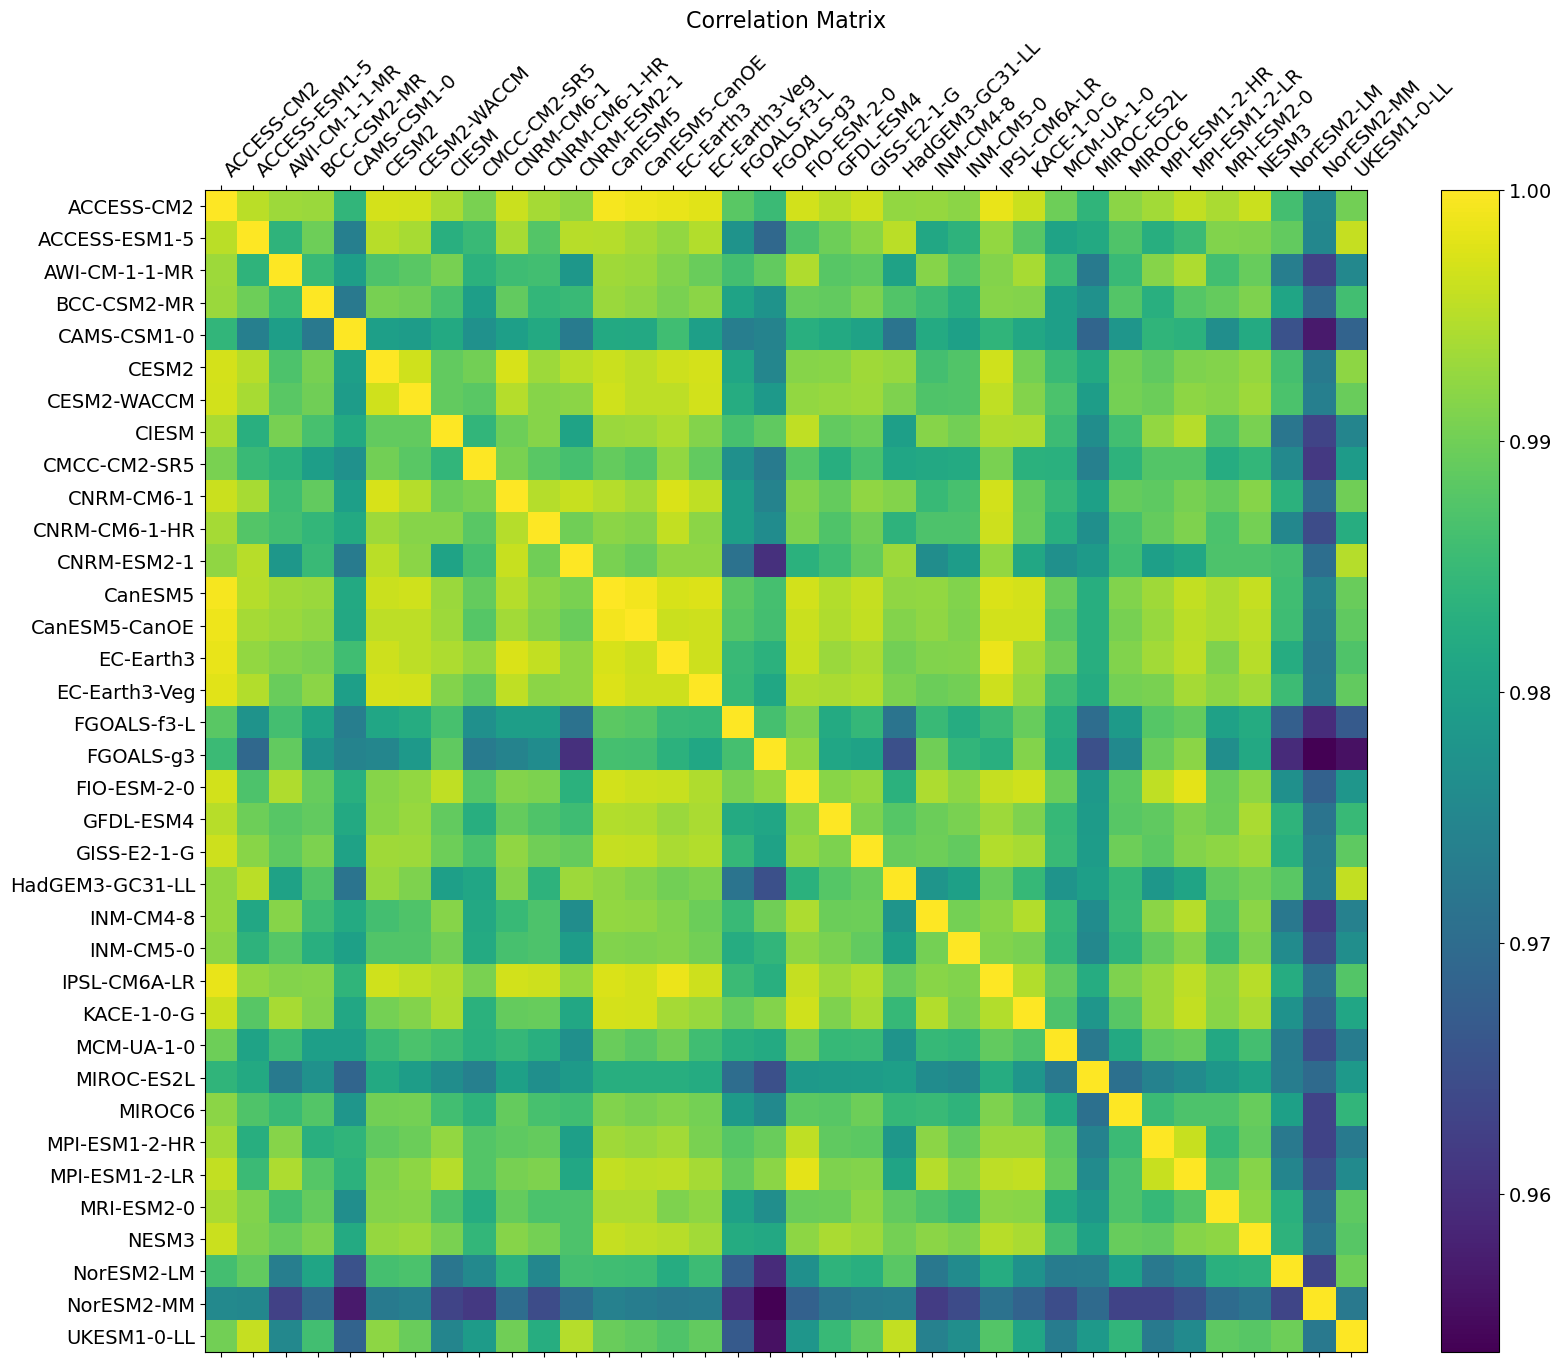

In [53]:
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Models Correlation Matrix', fontsize=16);

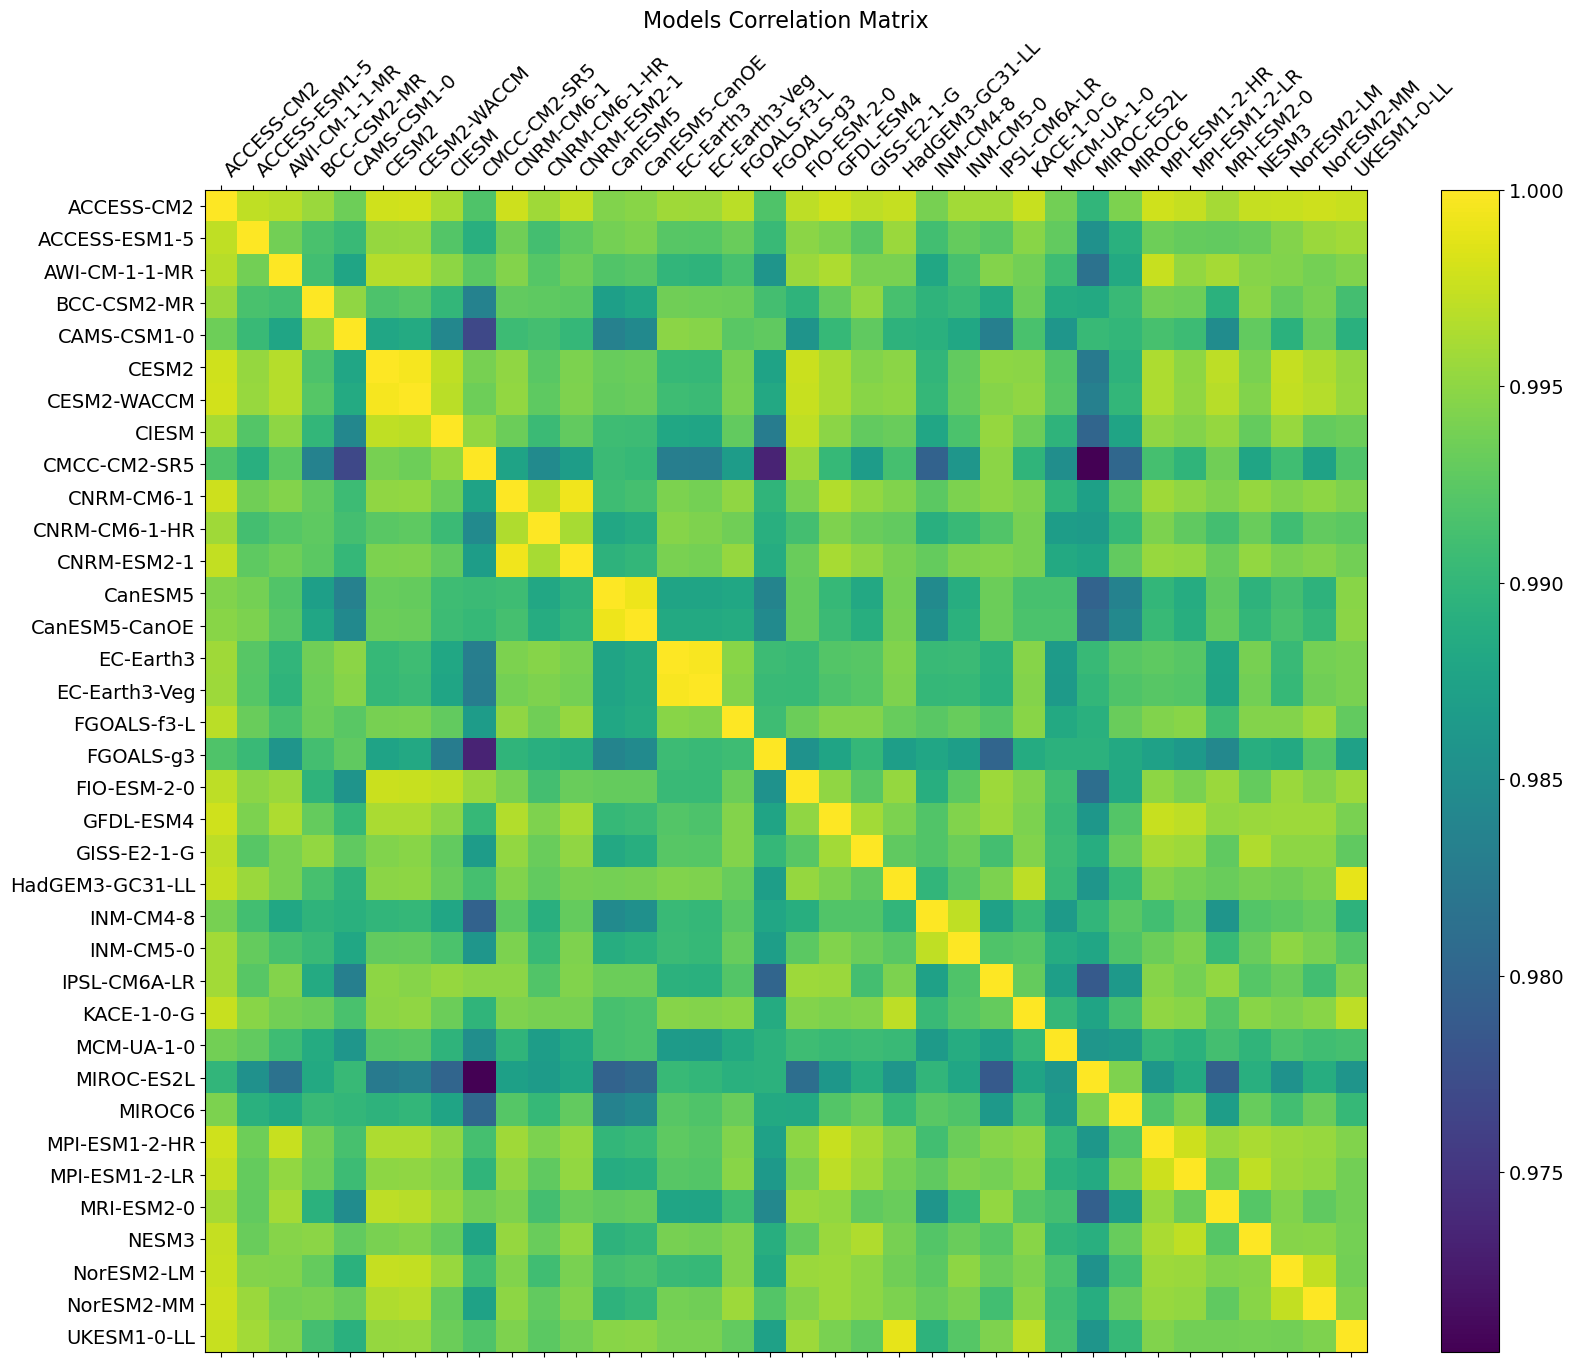

In [15]:
corr = corr_df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14, rotation=45, ha='left')
plt.yticks(range(corr.select_dtypes(['number']).shape[1]), corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Models Correlation Matrix', fontsize=16);

In [1]:
1

1